In [1]:
import os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [8]:
data = dict()
pids = dict()
base_dir = os.path.join('results', 'tmp')
for sample in os.listdir(base_dir):
    sample_data = dict()
    sample_path = os.path.join(base_dir, sample)
    for run in os.listdir(sample_path):
        if not run.endswith('.csv'): continue
        run_path = os.path.join(sample_path, run)
        run_name = run[0:run.index('.')]
        print('Loading', run_path)
        sample_data[run_name] = pd.read_csv(run_path)
    data[sample] = sample_data
    
    pid_data = pd.read_csv(os.path.join(sample_path, 'pid.txt'))
    pid_data_shifted = pid_data.copy()
    pid_data_shifted['cycle'] = pid_data_shifted['cycle'] - 1
    pid_data_shifted['pid'] = pid_data_shifted['pid'].shift(1)
    pid_data_shifted = pid_data_shifted.iloc[1:]
    pids[sample] = pd.merge_ordered(pid_data, pid_data_shifted)

Loading results/tmp/mcf_250B_50000_libquantum_1210B_10000/mcf_250B.csv
Loading results/tmp/mcf_250B_50000_libquantum_1210B_10000/libquantum_1210B.csv
Loading results/tmp/mcf_250B_50000_libquantum_1210B_10000/merged.csv


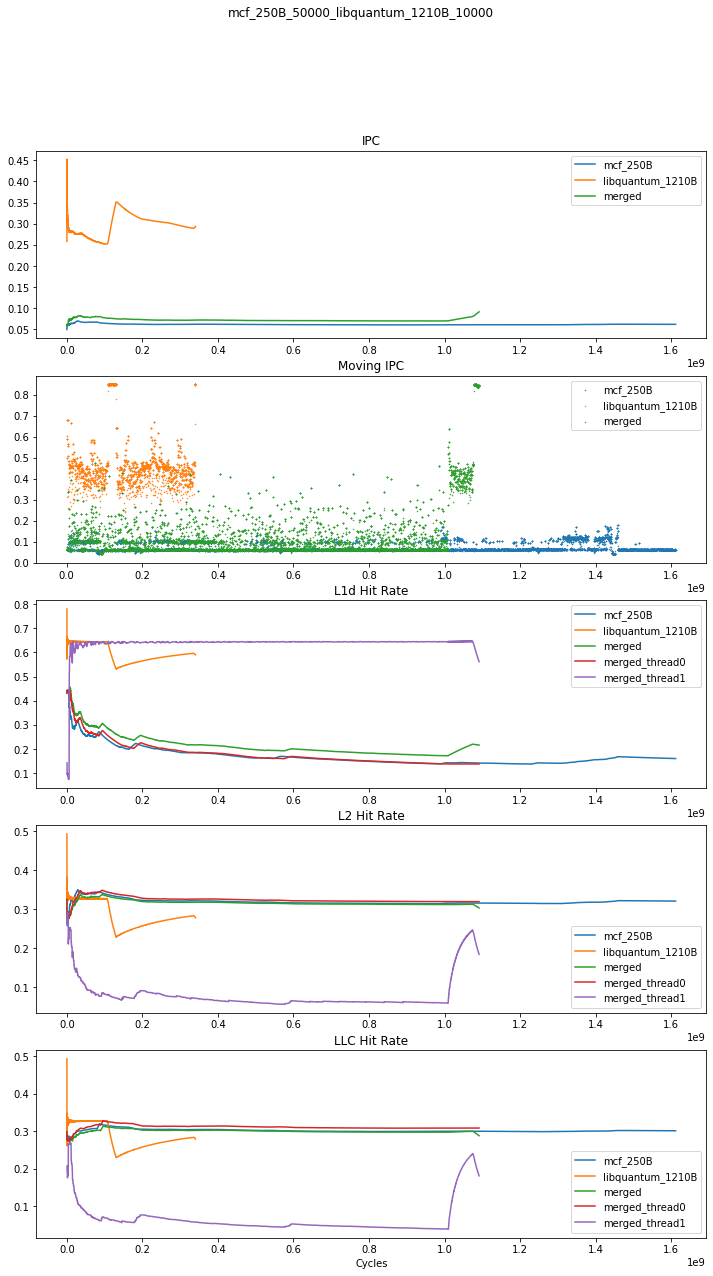

In [9]:
def plot_cache(cache, run, ax, data, cycles):
    cycles_len = len(cycles)
    accesses = current['total_accesses_{}'.format(cache)].iloc[0:cycles_len]
    hits = current['total_hits_{}'.format(cache)].iloc[0:cycles_len]
    ax.plot(cycles, hits / accesses, label=run)
    if run == 'merged':
        for i in range(2):
            accesses_per_thread = data['accesses_{}_thread{}'.format(cache, i)].iloc[0:cycles_len]
            hits_per_thread = data['hits_{}_thread{}'.format(cache, i)].iloc[0:cycles_len]
            ax.plot(cycles, hits_per_thread / accesses_per_thread, label='merged_thread{}'.format(i))

fit_to_min = False

for sample in data.keys():
    run_cycles = [x['cycle'] for x in data[sample].values()]
    min_run_cycles_idx = np.argmin([x.iloc[-1] for x in run_cycles])
    min_run_cycles = run_cycles[min_run_cycles_idx]
    min_run_cycles_len = len(min_run_cycles)
    
    fig, axs = plt.subplots(5, figsize=(12,20))
    fig.suptitle(sample)
    
    for run in data[sample].keys():
        current = data[sample][run]
        
        inst_count = current['retired_instructions']
        cycle_count = current['cycle']
        if fit_to_min:
            inst_count = inst_count.iloc[0:min_run_cycles_len]
            cycle_count = cycle_count.iloc[0:min_run_cycles_len]
        axs[0].plot(cycle_count, inst_count / cycle_count, label=run)
        
        inst_count_diff = inst_count.diff().iloc[1:].rolling(5).max()
        cycle_count_diff = cycle_count.diff().iloc[1:].rolling(5).max()
        axs[1].scatter(cycle_count.iloc[0:len(cycle_count_diff)], inst_count_diff / cycle_count_diff, s=0.25, label=run)
        
        if fit_to_min:
            plot_cache('L1d', run, axs[2], current, min_run_cycles)
            plot_cache('L2', run, axs[3], current, min_run_cycles)
            plot_cache('LLC', run, axs[4], current, min_run_cycles)
        else:
            plot_cache('L1d', run, axs[2], current, current['cycle'])
            plot_cache('L2', run, axs[3], current, current['cycle'])
            plot_cache('LLC', run, axs[4], current, current['cycle'])
    
    for ax in axs:
        # ax.plot(pids[sample]['cycle'], pids[sample]['pid'], 'k--')
        pass
    
    axs[0].set_title('IPC')
    axs[0].legend()
    axs[1].set_title('Moving IPC')
    axs[1].legend()
    axs[2].set_title('L1d Hit Rate')
    axs[2].legend()
    axs[3].set_title('L2 Hit Rate')
    axs[3].legend()
    axs[4].set_title('LLC Hit Rate')
    axs[4].legend()
    axs[4].set_xlabel('Cycles')
    
    plt.show()